# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


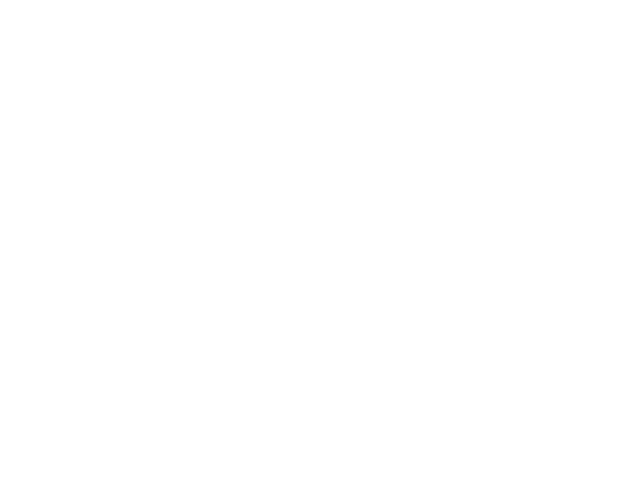

In [4]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    plt.close()
    plt.imshow(sample_img)

In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    return_array = np.zeros((out_size,out_size,3), dtype=int)
    n_windows = int(out_size/patch_size)
    for i in range(n_windows):
        for j in range(n_windows):
            x = np.random.randint(0, sample.shape[1]-patch_size)
            y = np.random.randint(0, sample.shape[0]-patch_size)
            return_array[i*patch_size:i*patch_size+patch_size,j*patch_size:j*patch_size+patch_size,:] = sample[y:y+patch_size,x:x+patch_size,:]
    return return_array

<IPython.core.display.Javascript object>


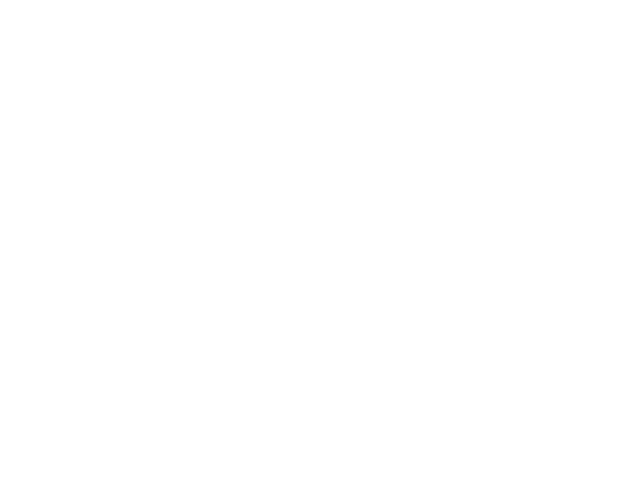

In [6]:
out_size = 400  # feel free to change to debug
patch_size = 50 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
if res.any():
    plt.close()
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [7]:
def ssd_patch(mask, template, texture_img):
    out_size = texture_img.shape[0]
    patch_size = mask.shape[0]
    #offset = int(patch_size/2)
    #ssd_img = np.ones((out_size-patch_size+1,out_size-patch_size+1))
    n_windows = out_size-patch_size+1
    I = texture_img/255
    M = mask
    T = template/255
    #for r in range(n_windows):
    #    for c in range(n_windows):
    #        texture_patch = texture_img[r:r+patch_size,c:c+patch_size,:]
    #        ssd = np.sum(np.square(template - (texture_patch*mask)))
    #        ssd_img[r,c] = ssd
    

    hp = int(.5*patch_size)
    ssd_img = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    ssd_img = ssd_img[hp:ssd_img.shape[0]-hp,hp:ssd_img.shape[1]-hp]
    ssd_img = ssd_img - np.min(ssd_img)
    ssd_img = ssd_img/np.max(ssd_img)
    return ssd_img

In [8]:
def choose_sample(ssd_img, patch_size, texture_img, k=5):
    
    ssd_rvl = ssd_img.ravel()
    mink = ssd_rvl[np.argpartition(ssd_rvl, k)[k-1]]  
    where_a = np.where(ssd_img<=mink)
    p = patch_size
    i = np.random.randint(0, where_a[0].shape[0])
    r = where_a[0][i]
    c = where_a[1][i]
    return_patch = texture_img[r:r+p,c:c+p,:]
    #print(f'return patch shape: {return_patch.shape}')
    return return_patch

In [9]:
def set_mask(r, c, patch_size, overlap):
    return_mask = np.zeros((patch_size,patch_size,3))
    v = False
    h = False
    if r > 0:
        return_mask[0:overlap,:,:] = np.ones((overlap,patch_size,3))
        h = True    #we need a horizontal cut
    if c > 0:
        return_mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
        v = True    #we need a vertical cut
    if r==0 and c==0:
        return_mask = 1 - return_mask
    return return_mask, v, h

In [10]:
def quilt_simple(sample, out_size, patch_size, overlap, k):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :return: numpy.ndarray
    """
    # Todo 
    x = np.random.randint(0, sample.shape[1]-patch_size)
    y = np.random.randint(0, sample.shape[0]-patch_size)

    n_windows = int((out_size-overlap)/(patch_size-overlap))
    return_img = np.zeros((out_size,out_size,3), dtype=int)
    
    seed_patch = sample[y:y+patch_size,x:x+patch_size,:]
    return_img[0:0+patch_size,0:0+patch_size,:] = seed_patch

    for r in range(n_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_windows): #n_windows
            mask, _, _ = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            ssd_img = ssd_patch(mask,template,sample)
            
            match_patch = choose_sample(ssd_img,patch_size,sample,k)
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] = match_patch
    
    return return_img

<IPython.core.display.Javascript object>


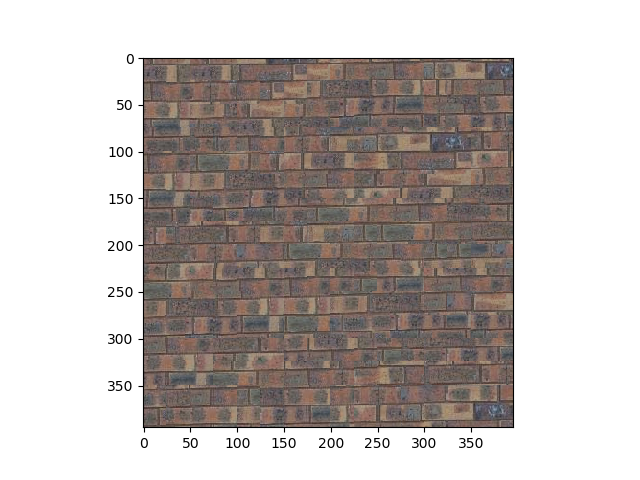

In [12]:
res = quilt_simple(sample_img, 395, 45, 20, 5) #feel free to change parameters to get best results


if res.any():
    plt.close()
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [13]:
def quilt_cut(sample, out_size, patch_size, overlap, k):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param k: int
    :return: numpy.ndarray
    """
    x = np.random.randint(0, sample.shape[1]-patch_size)
    y = np.random.randint(0, sample.shape[0]-patch_size)

    n_windows = int((out_size-overlap)/(patch_size-overlap))
    return_img = np.zeros((out_size,out_size,3), dtype=int)
    
    seed_patch = sample[y:y+patch_size,x:x+patch_size,:]
    return_img[0:0+patch_size,0:0+patch_size,:] = seed_patch

    for r in range(n_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_windows): #n_windows
            mask, v, h = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            ssd_img = ssd_patch(mask,template,sample)
            
            match_patch = choose_sample(ssd_img,patch_size,sample,k)
            mask_2d = np.ones((mask.shape[0],mask.shape[1]),dtype=int)
            
            if h:
                patch_overlap = match_patch[0:overlap,:,:]
                template_overlap = template[template.shape[0]-overlap:template.shape[0],:,:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost)
                mask_2d[0:overlap,:] = mask_2d[0:overlap,:]& bnd_mask
                
            if v:
                patch_overlap = match_patch[:,0:overlap,:]
                template_overlap = template[:,template.shape[1]-overlap:template.shape[1],:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost.T).T
                mask_2d[:,0:overlap] = mask_2d[:,0:overlap]& bnd_mask
            
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            mask = np.stack((mask_2d,mask_2d,mask_2d),axis=2)
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] *= 1 - mask
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] += match_patch * mask
    
    return return_img

(395, 395, 3)


<IPython.core.display.Javascript object>


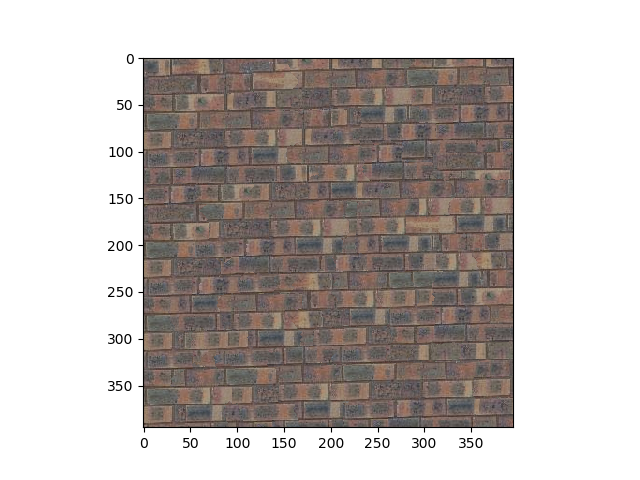

In [18]:
res = quilt_cut(sample_img, 395, 45, 20, 3)
#if res.any():
print(res.shape)
plt.close()
plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [19]:
def blur_img(img,kernel_size=None):
    if kernel_size is None:
        kernel_size = int(min(img.shape[0],img.shape[1])/15)
    if kernel_size % 2 == 0:
        kernel_size += 1
    blur_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),cv2.BORDER_DEFAULT)

    return blur_img

In [20]:
def texture_transfer(source_texture, target_img, patch_size, overlap, k, alpha):
    """
    Feel free to add function parameters
    """
    
    assert(alpha <= 1 and alpha >= 0)
    assert(patch_size % 2 == 1)
    target_img_hsv = cv2.cvtColor(target_img,cv2.COLOR_RGB2HSV)
    source_texture_hsv = cv2.cvtColor(source_texture,cv2.COLOR_RGB2HSV) 
    
    [h_ti,s_ti,v_ti] = [target_img_hsv[:,:,0],target_img_hsv[:,:,1],target_img_hsv[:,:,2]]
    [h_st,s_st,v_st] = [source_texture_hsv[:,:,0],source_texture_hsv[:,:,1],source_texture_hsv[:,:,2]]

    source_texture_coor = blur_img(v_st)
    target_img_coor = blur_img(v_ti)
    
    x = 0 #np.random.randint(0, sample.shape[1]-patch_size)
    y = 0 #np.random.randint(0, sample.shape[0]-patch_size)

    n_r_windows = int((target_img.shape[0]-overlap)/(patch_size-overlap))
    n_c_windows = int((target_img.shape[1]-overlap)/(patch_size-overlap))
    return_img = np.zeros((target_img.shape[0],target_img.shape[1],3), dtype=int)
    
    seed_target_patch = target_img_coor[y:y+patch_size,x:x+patch_size]
    ssd_transfer = ssd_patch(np.ones((patch_size,patch_size)),seed_target_patch,source_texture_coor)
    match_patch = choose_sample(ssd_transfer,patch_size,source_texture,k)
    return_img[0:0+patch_size,0:0+patch_size,:] = match_patch

    for r in range(n_r_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_c_windows): #n_windows
            mask, v, h = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            overlap_template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            target_template = target_img_coor[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size]
            
            ssd_overlap = ssd_patch(mask,overlap_template,source_texture)
            ssd_transfer = ssd_patch(mask[:,:,0].reshape((mask.shape[0],-1)),target_template,source_texture_coor)
            ssd_transfer = np.stack((ssd_transfer,ssd_transfer,ssd_transfer),axis=2)
            ssd_img = alpha * ssd_overlap + (1-alpha) * ssd_transfer
            ssd_img = ssd_img - np.min(ssd_img)
            ssd_img = ssd_img/np.max(ssd_img)
            match_patch = choose_sample(ssd_img,patch_size,source_texture,k)
            mask_2d = np.ones((mask.shape[0],mask.shape[1]),dtype=int)
            
            if h:
                patch_overlap = match_patch[0:overlap,:,:]
                template_overlap = overlap_template[overlap_template.shape[0]-overlap:overlap_template.shape[0],:,:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost)
                mask_2d[0:overlap,:] = mask_2d[0:overlap,:]& bnd_mask
                
            if v:
                patch_overlap = match_patch[:,0:overlap,:]
                template_overlap = overlap_template[:,overlap_template.shape[1]-overlap:overlap_template.shape[1],:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost.T).T
                mask_2d[:,0:overlap] = mask_2d[:,0:overlap]& bnd_mask
            
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            mask = np.stack((mask_2d,mask_2d,mask_2d),axis=2)
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] *= 1 - mask
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] += match_patch * mask
            

    return return_img

<IPython.core.display.Javascript object>


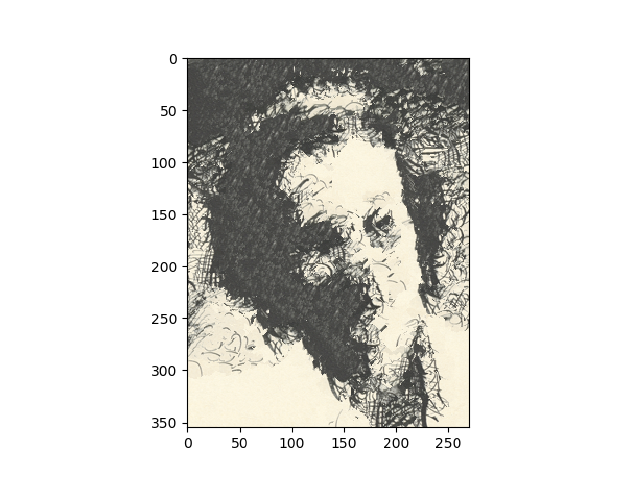

In [24]:
target_img = 'samples/feynman.tiff'
source_texture = 'samples/sketch.tiff'

target_img = cv2.imread(target_img)
source_texture = cv2.imread(source_texture)


target_img_rgb = cv2.cvtColor(target_img,cv2.COLOR_BGR2RGB)
#target_img_hsv = cv2.cvtColor(target_img_rgb,cv2.COLOR_RGB2HSV) 

source_texture_rgb = cv2.cvtColor(source_texture,cv2.COLOR_BGR2RGB)
#source_texture_hsv = cv2.cvtColor(source_texture_rgb,cv2.COLOR_RGB2HSV) 


#[h_ti,s_ti,v_ti] = [target_img_hsv[:,:,0],target_img_hsv[:,:,1],target_img_hsv[:,:,2]]
#[h_st,s_st,v_st] = [source_texture_hsv[:,:,0],source_texture_hsv[:,:,1],source_texture_hsv[:,:,2]]
#
#source_texture_coor = blur_img(v_st)
#target_img_coor = blur_img(v_ti)

transfer_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=31, overlap=25, k=40, alpha=0.2)

plt.close()
plt.imshow(transfer_img)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).